# NB01: Data Extraction and Quality Assessment

**Project**: ADP1 Deletion Collection Phenotype Analysis

**Goal**: Load growth matrix from SQLite, assess completeness, validate distributions, and save clean data files for downstream analysis.

**Outputs**:
- `data/growth_matrix_complete.csv` — 2,034 genes with data on all 8 conditions
- `data/growth_matrix_all.csv` — 2,350 genes with data on any condition
- `data/all_genes_annotated.csv` — all 5,852 genes with annotations and TnSeq classification
- Distribution plots per condition
- Completeness summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

# Paths
DB_PATH = '../user_data/berdl_tables.db'
DATA_DIR = '../data'
FIG_DIR = '../figures'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Growth condition columns
GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '') for c in GROWTH_COLS]

print(f'Database: {os.path.realpath(DB_PATH)}')

Database: /home/psdehal/pangenome_science/BERIL-research-observatory/projects/acinetobacter_adp1_explorer/user_data/berdl_tables.db


## 1. Load all genes from SQLite

In [2]:
conn = sqlite3.connect(DB_PATH)

df_all = pd.read_sql_query("""
    SELECT feature_id, old_locus_tag, gene_names,
           rast_function, cog, ec, ko, pfam,
           essentiality_minimal, essentiality_lb,
           pangenome_cluster_id, pangenome_is_core,
           start, end, length, strand, contig_id,
           minimal_media_class, rich_media_class,
           mutant_growth_acetate, mutant_growth_asparagine,
           mutant_growth_butanediol, mutant_growth_glucarate,
           mutant_growth_glucose, mutant_growth_lactate,
           mutant_growth_quinate, mutant_growth_urea
    FROM genome_features
""", conn)
conn.close()

print(f'Total genes loaded: {len(df_all):,}')
print(f'Columns: {len(df_all.columns)}')
df_all.head()

Total genes loaded: 5,852
Columns: 27


,feature_id,old_locus_tag,gene_names,rast_function,cog,ec,ko,pfam,essentiality_minimal,essentiality_lb,...,minimal_media_class,rich_media_class,mutant_growth_acetate,mutant_growth_asparagine,mutant_growth_butanediol,mutant_growth_glucarate,mutant_growth_glucose,mutant_growth_lactate,mutant_growth_quinate,mutant_growth_urea
0,ACIAD_RS16655,NaN,rpmH,LSU ribosomal protein L34p,COG0230,NaN,K02914,PF00468,uncertain,uncertain,...,essential,essential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACIAD_RS16650,NaN,rnpA,Ribonuclease P protein component (EC 3.1.26.5),NaN,3.1.26.5,K03536,PF01288,uncertain,uncertain,...,essential,essential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACIAD_RS16645,ACIAD3682,yidD,Membrane protein insertion efficiency factor YidD,NaN,NaN,K08998,PF01809,dispensable,uncertain,...,NaN,NaN,0.377931,0.747155,0.656207,1.211466,1.33224,0.804741,1.401635,0.291465
3,ACIAD_RS16640,NaN,yidC,Inner membrane protein translocase and chapero...,NaN,NaN,K03217,PF14849,uncertain,essential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACIAD_RS16635,NaN,mnmE,tRNA-5-carboxymethylaminomethyl-2-thiouridine(...,NaN,3.6.-.-,K03650,PF10396,uncertain,uncertain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data completeness overview

In [3]:
# Growth data coverage
has_any_growth = df_all[GROWTH_COLS].notna().any(axis=1)
has_all_growth = df_all[GROWTH_COLS].notna().all(axis=1)

# TnSeq coverage
has_tnseq = df_all['essentiality_minimal'].notna()

# Annotation coverage
has_rast = df_all['rast_function'].notna()
has_ko = df_all['ko'].notna()
has_pfam = df_all['pfam'].notna()
has_cog = df_all['cog'].notna()

print('=== Data Coverage ===')
print(f'Total genes:                {len(df_all):>6,}')
print(f'With growth data (any):     {has_any_growth.sum():>6,} ({has_any_growth.mean():.1%})')
print(f'With growth data (all 8):   {has_all_growth.sum():>6,} ({has_all_growth.mean():.1%})')
print(f'With TnSeq (minimal):       {has_tnseq.sum():>6,} ({has_tnseq.mean():.1%})')
print(f'With both growth + TnSeq:   {(has_any_growth & has_tnseq).sum():>6,}')
print()
print('=== Annotation Coverage ===')
print(f'RAST function:              {has_rast.sum():>6,} ({has_rast.mean():.1%})')
print(f'KO terms:                   {has_ko.sum():>6,} ({has_ko.mean():.1%})')
print(f'PFAM domains:               {has_pfam.sum():>6,} ({has_pfam.mean():.1%})')
print(f'COG IDs:                    {has_cog.sum():>6,} ({has_cog.mean():.1%})')

=== Data Coverage ===
Total genes:                 5,852
With growth data (any):      2,350 (40.2%)
With growth data (all 8):    2,034 (34.8%)
With TnSeq (minimal):        3,405 (58.2%)
With both growth + TnSeq:    2,324

=== Annotation Coverage ===
RAST function:               3,235 (55.3%)
KO terms:                    1,984 (33.9%)
PFAM domains:                3,235 (55.3%)
COG IDs:                       354 (6.0%)


In [4]:
# Per-condition coverage
print('=== Per-Condition Coverage ===')
for col, name in zip(GROWTH_COLS, CONDITION_NAMES):
    n = df_all[col].notna().sum()
    mean_val = df_all[col].mean()
    median_val = df_all[col].median()
    print(f'{name:15s}  n={n:>5,}  mean={mean_val:.3f}  median={median_val:.3f}')

=== Per-Condition Coverage ===
acetate          n=2,279  mean=0.562  median=0.566
asparagine       n=2,312  mean=0.798  median=0.809
butanediol       n=2,300  mean=0.644  median=0.650
glucarate        n=2,222  mean=1.254  median=1.266
glucose          n=2,251  mean=1.298  median=1.323
lactate          n=2,316  mean=0.810  median=0.822
quinate          n=2,310  mean=1.355  median=1.381
urea             n=2,312  mean=0.409  median=0.411


## 3. TnSeq classification breakdown

In [5]:
# TnSeq essentiality classes
print('=== TnSeq Essentiality (Minimal Media) ===')
tnseq_counts = df_all['essentiality_minimal'].value_counts(dropna=False)
for cls, count in tnseq_counts.items():
    label = cls if pd.notna(cls) else 'No TnSeq data'
    print(f'{label:20s}  {count:>5,}')

print()
print('=== TnSeq × Growth Data Cross-tabulation ===')
df_all['has_growth'] = has_any_growth
ct = pd.crosstab(df_all['essentiality_minimal'].fillna('No TnSeq'), 
                 df_all['has_growth'].map({True: 'Has growth', False: 'No growth'}),
                 margins=True)
print(ct)

=== TnSeq Essentiality (Minimal Media) ===
dispensable           2,593
No TnSeq data         2,447
essential               499
uncertain               313

=== TnSeq × Growth Data Cross-tabulation ===
has_growth            Has growth  No growth   All
essentiality_minimal                             
No TnSeq                      26       2421  2447
dispensable                 2321        272  2593
essential                      0        499   499
uncertain                      3        310   313
All                         2350       3502  5852


## 4. Growth ratio distributions per condition

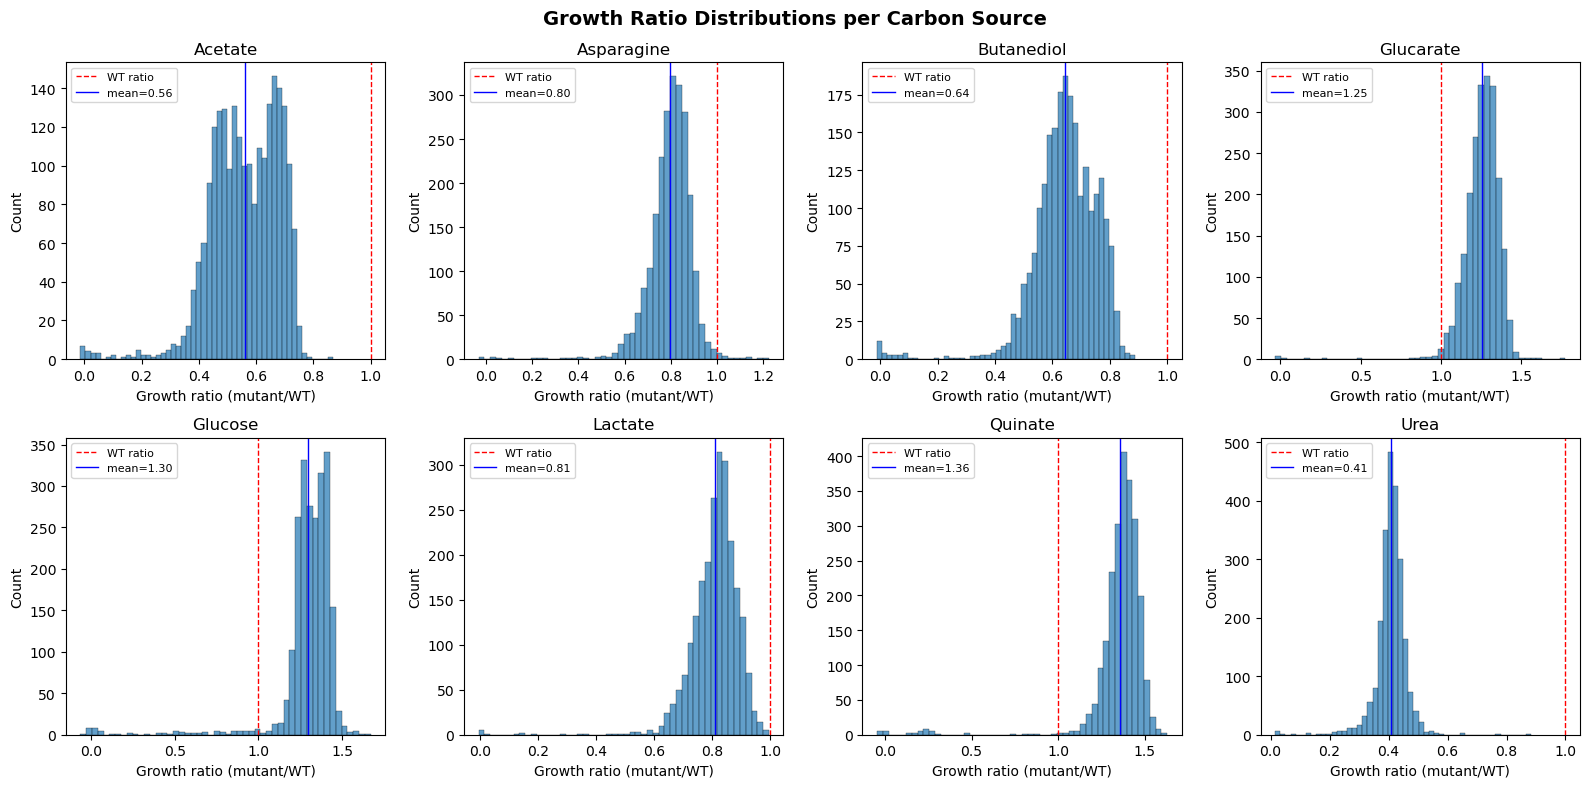

Saved: figures/growth_distributions.png


In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Growth Ratio Distributions per Carbon Source', fontsize=14, fontweight='bold')

for ax, col, name in zip(axes.flat, GROWTH_COLS, CONDITION_NAMES):
    data = df_all[col].dropna()
    ax.hist(data, bins=50, edgecolor='black', linewidth=0.3, alpha=0.7)
    ax.axvline(1.0, color='red', linestyle='--', linewidth=1, label='WT ratio')
    ax.axvline(data.mean(), color='blue', linestyle='-', linewidth=1, label=f'mean={data.mean():.2f}')
    ax.set_title(name.capitalize(), fontsize=12)
    ax.set_xlabel('Growth ratio (mutant/WT)')
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'growth_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/growth_distributions.png')

## 5. Demanding vs robust conditions

/tmp/ipykernel_6457/1302587482.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='condition', y='growth_ratio', order=order, ax=ax,


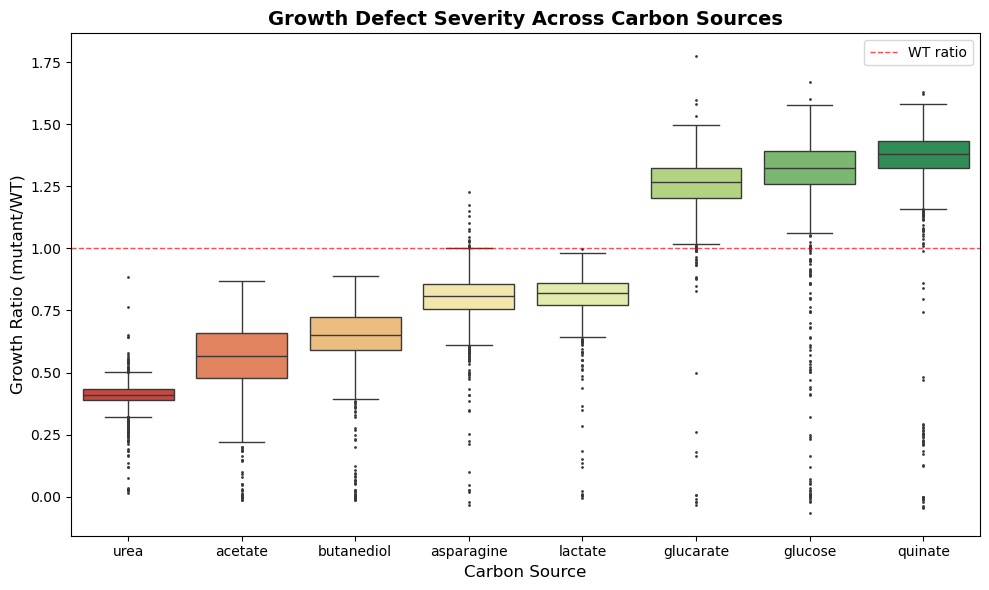

Saved: figures/condition_boxplots.png


In [7]:
# Box plot comparing conditions
df_melt = df_all[GROWTH_COLS].melt(var_name='condition', value_name='growth_ratio')
df_melt['condition'] = df_melt['condition'].str.replace('mutant_growth_', '')
df_melt = df_melt.dropna()

# Order by mean growth ratio
order = df_melt.groupby('condition')['growth_ratio'].mean().sort_values().index.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_melt, x='condition', y='growth_ratio', order=order, ax=ax,
            fliersize=1, palette='RdYlGn')
ax.axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='WT ratio')
ax.set_xlabel('Carbon Source', fontsize=12)
ax.set_ylabel('Growth Ratio (mutant/WT)', fontsize=12)
ax.set_title('Growth Defect Severity Across Carbon Sources', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'condition_boxplots.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/condition_boxplots.png')

In [8]:
# Fraction of genes with growth defects per condition (ratio < 0.8)
print('=== Fraction of Genes with Growth Defects (ratio < 0.8) ===')
for col, name in zip(GROWTH_COLS, CONDITION_NAMES):
    data = df_all[col].dropna()
    n_defect = (data < 0.8).sum()
    print(f'{name:15s}  {n_defect:>5,} / {len(data):>5,}  ({n_defect/len(data):.1%})')

print()
print('=== Fraction with Severe Defects (ratio < 0.5) ===')
for col, name in zip(GROWTH_COLS, CONDITION_NAMES):
    data = df_all[col].dropna()
    n_severe = (data < 0.5).sum()
    print(f'{name:15s}  {n_severe:>5,} / {len(data):>5,}  ({n_severe/len(data):.1%})')

=== Fraction of Genes with Growth Defects (ratio < 0.8) ===
acetate          2,278 / 2,279  (100.0%)
asparagine       1,049 / 2,312  (45.4%)
butanediol       2,188 / 2,300  (95.1%)
glucarate           10 / 2,222  (0.5%)
glucose             55 / 2,251  (2.4%)
lactate            863 / 2,316  (37.3%)
quinate             38 / 2,310  (1.6%)
urea             2,311 / 2,312  (100.0%)

=== Fraction with Severe Defects (ratio < 0.5) ===
acetate            715 / 2,279  (31.4%)
asparagine          21 / 2,312  (0.9%)
butanediol         154 / 2,300  (6.7%)
glucarate           10 / 2,222  (0.5%)
glucose             32 / 2,251  (1.4%)
lactate             16 / 2,316  (0.7%)
quinate             36 / 2,310  (1.6%)
urea             2,264 / 2,312  (97.9%)


## 6. Complete matrix — genes with all 8 conditions

In [9]:
# Extract complete matrix
df_complete = df_all[has_all_growth].copy()
print(f'Complete matrix: {len(df_complete):,} genes × 8 conditions')
print()

# Summary statistics for the complete matrix
print('=== Complete Matrix Summary Statistics ===')
print(df_complete[GROWTH_COLS].describe().round(3).to_string())

Complete matrix: 2,034 genes × 8 conditions

=== Complete Matrix Summary Statistics ===
       mutant_growth_acetate  mutant_growth_asparagine  mutant_growth_butanediol  mutant_growth_glucarate  mutant_growth_glucose  mutant_growth_lactate  mutant_growth_quinate  mutant_growth_urea
count               2034.000                  2034.000                  2034.000                 2034.000               2034.000               2034.000               2034.000            2034.000
mean                   0.564                     0.799                     0.651                    1.257                  1.306                  0.816                  1.363               0.408
std                    0.115                     0.087                     0.111                    0.111                  0.166                  0.077                  0.163               0.050
min                   -0.014                    -0.032                    -0.012                   -0.011                 -0.021    

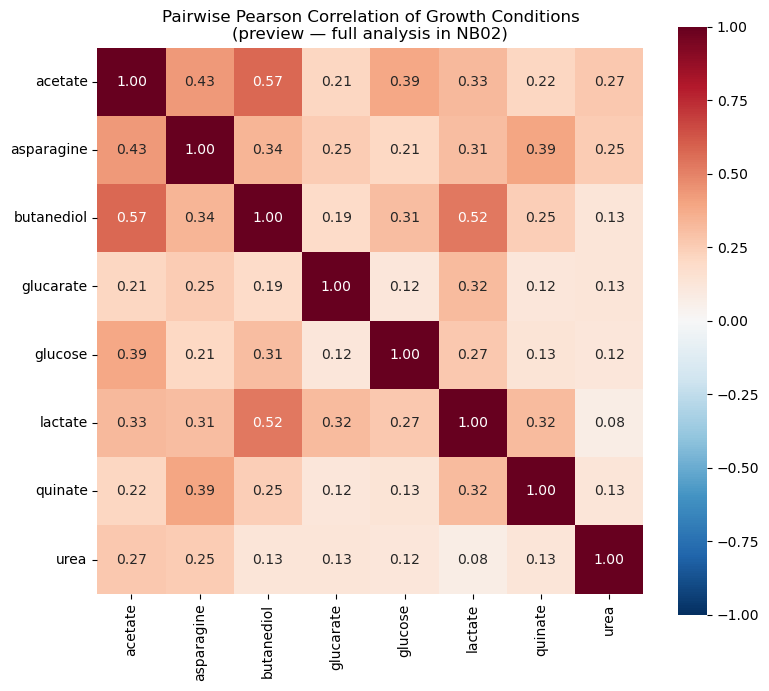

Saved: figures/condition_correlation_preview.png


In [10]:
# Pairwise correlation preview (full analysis in NB02)
growth_matrix = df_complete[GROWTH_COLS].rename(
    columns={c: c.replace('mutant_growth_', '') for c in GROWTH_COLS}
)
corr = growth_matrix.corr(method='pearson')

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Pairwise Pearson Correlation of Growth Conditions\n(preview — full analysis in NB02)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'condition_correlation_preview.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/condition_correlation_preview.png')

## 7. Save data files

In [11]:
# Save complete growth matrix
df_complete.to_csv(os.path.join(DATA_DIR, 'growth_matrix_complete.csv'), index=False)
print(f'Saved: data/growth_matrix_complete.csv ({len(df_complete):,} rows)')

# Save all genes with any growth data
df_with_growth = df_all[has_any_growth].copy()
df_with_growth.to_csv(os.path.join(DATA_DIR, 'growth_matrix_all.csv'), index=False)
print(f'Saved: data/growth_matrix_all.csv ({len(df_with_growth):,} rows)')

# Save all genes with annotations (for TnSeq gap analysis in NB05)
df_all.drop(columns=['has_growth'], errors='ignore').to_csv(
    os.path.join(DATA_DIR, 'all_genes_annotated.csv'), index=False
)
print(f'Saved: data/all_genes_annotated.csv ({len(df_all):,} rows)')

Saved: data/growth_matrix_complete.csv (2,034 rows)
Saved: data/growth_matrix_all.csv (2,350 rows)
Saved: data/all_genes_annotated.csv (5,852 rows)


In [12]:
print('\n=== NB01 Summary ===')
print(f'Total genes:          {len(df_all):>6,}')
print(f'With any growth data: {has_any_growth.sum():>6,}')
print(f'Complete matrix:      {has_all_growth.sum():>6,}')
print(f'With TnSeq:           {has_tnseq.sum():>6,}')
print(f'\nFiles saved to data/:')
for f in sorted(os.listdir(DATA_DIR)):
    size = os.path.getsize(os.path.join(DATA_DIR, f))
    print(f'  {f:40s} {size/1024:.0f} KB')


=== NB01 Summary ===
Total genes:           5,852
With any growth data:  2,350
Complete matrix:       2,034
With TnSeq:            3,405

Files saved to data/:
  all_genes_annotated.csv                  1402 KB
  growth_matrix_all.csv                    599 KB
  growth_matrix_complete.csv               520 KB
